<a href="https://colab.research.google.com/github/JasmithaM14/Dissertation/blob/main/FinalDissertation_PCOS_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5
BASE_DIR = '/content/drive/MyDrive/Final_Dissertation/DATA'  # Adjust this path to your dataset location


data_dir = BASE_DIR


def explore_data(directory):
    """Explore the dataset and generate basic statistics"""

    # For this dataset, we know we have just two classes
    classes = ["infected", "noninfected"]
    class_counts = {}

    # Count images in each class
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images

    # Print statistics
    print(f"Total classes: {len(class_counts)}")
    print("Class distribution:")
    for class_name, count in class_counts.items():
        print(f"  - {class_name}: {count} images")

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution in Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')

    # Annotate bars with counts
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    plt.savefig('class_distribution.png')
    plt.show()

    return class_counts



Total classes: 2
Class distribution:
  - infected: 6784 images
  - noninfected: 5000 images


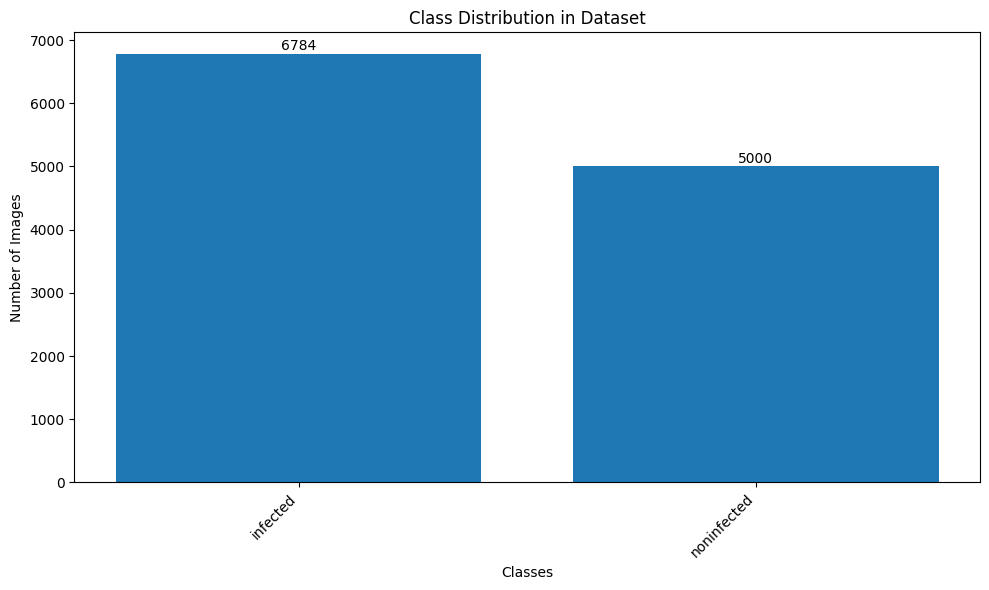

<Figure size 640x480 with 0 Axes>

In [ ]:
class_counts = explore_data(data_dir)
num_classes = len(class_counts)


Data Preparation and Augumentation


Shuffling and organizing data...

Creating data generators...
Found 11049 images belonging to 2 classes.
Found 5157 images belonging to 2 classes.

Visualizing augmented images...


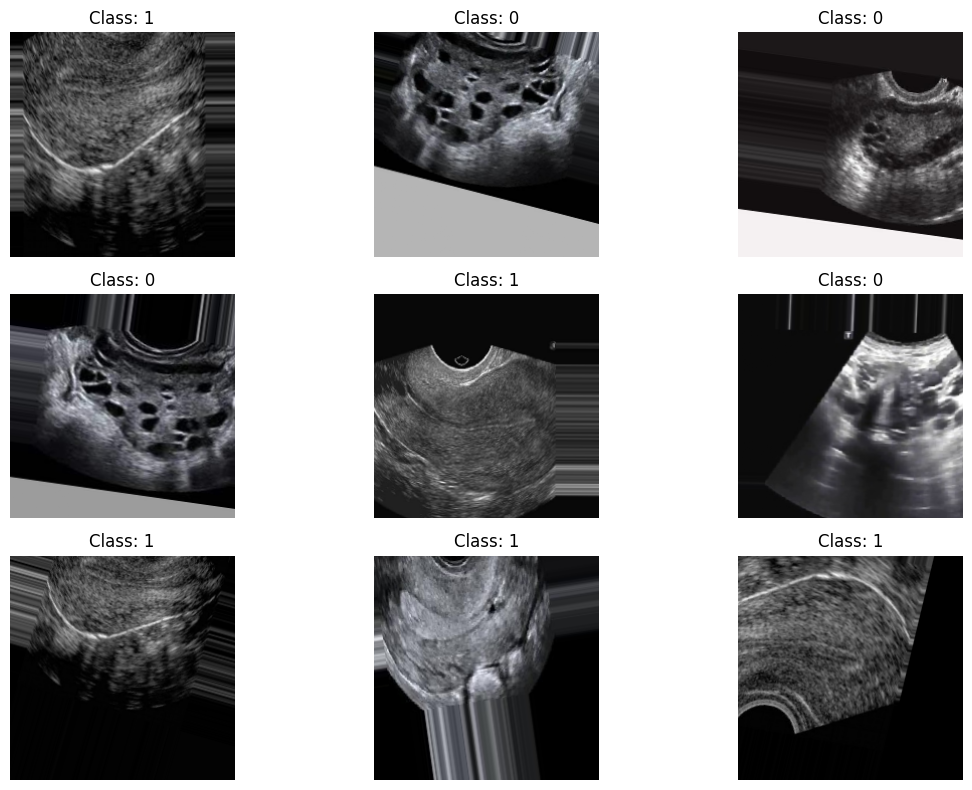

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import random
from shutil import copyfile

# Constants
IMG_SIZE = 224  # Assuming this size, adjust as needed
BATCH_SIZE = 32  # Adjust as needed

def shuffle_and_organize_data(data_dir, output_dir):
    """
    Shuffles all images and organizes them into train and validation folders
    """
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get all classes
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    for class_name in classes:
        # Create class directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Get all images for this class
        class_dir = os.path.join(data_dir, class_name)
        images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

        # Shuffle images
        random.shuffle(images)

        # Split into train (75%) and validation (25%)
        split_idx = int(len(images) * 0.75)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copy images to their respective folders
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(train_dir, class_name, img)
            copyfile(src, dst)

        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(val_dir, class_name, img)
            copyfile(src, dst)

    return train_dir, val_dir

def create_data_generators(train_dir, val_dir):
    """
    Creates separate data generators for training and validation
    with augmentation only for training data
    """
    # For training data - with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )

    # For validation data - only rescaling, no augmentation
    valid_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators using separate directories
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = valid_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # This should be False for consistent evaluation
    )

    return train_generator, validation_generator

def visualize_augmentation(train_generator):
    """Visualize some augmented training samples"""

    plt.figure(figsize=(12, 8))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        batch = next(train_generator)
        image = batch[0][0]  # Get the first image from batch
        plt.imshow(image)
        plt.title(f"Class: {np.argmax(batch[1][0])}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('augmented_samples.png')
    plt.show()

# Usage example
data_dir = "/content/drive/MyDrive/Final_Dissertation/DATA"  # Path to your original data
output_dir = "/content/drive/MyDrive/Final_Dissertation/Organised_Data"  # Path where to store organized data

# 1. Shuffle and organize data into train/val directories
print("Shuffling and organizing data...")
train_dir, val_dir = shuffle_and_organize_data(data_dir, output_dir)

# 2. Create data generators
print("\nCreating data generators...")
train_generator, validation_generator = create_data_generators(train_dir, val_dir)

# 3. Visualize augmented images
print("\nVisualizing augmented images...")
visualize_augmentation(train_generator)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
IMG_SIZE = 224  # Assuming this size, adjust as needed
BATCH_SIZE = 32
EPOCHS = 5 # Adjust as needed

# 4. Build the CNN Model
def build_model(num_classes):
    """Build and compile the CNN model for categorical classification"""

    model = Sequential()

    # First Conv Block
    model.add(Conv2D(10, (5, 5), padding='valid', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling2D(pool_size=(4, 4)))

    # Second Conv Block
    model.add(Conv2D(12, (5, 5), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))

    # Flatten layer
    model.add(Flatten())

    # Output layer - output size matches number of classes
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary for debugging
    model.summary()

    return model


def train_model(model, train_generator, validation_generator):
    """Train the model with callbacks for best performance"""

    # Define callbacks
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

    return history, model


def evaluate_model(history, model, validation_generator):
    """Evaluate model performance and visualize results for multi-class classification"""

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    # Get predictions
    validation_steps = validation_steps = int(np.ceil(validation_generator.samples / BATCH_SIZE))
    Y_pred = model.predict(validation_generator, steps=validation_steps)
    y_pred = np.argmax(Y_pred, axis=1)

    # Get true classes (only as many as we have predictions for)
    y_true = validation_generator.classes[:len(y_pred)]

    # Get class names
    class_names = list(validation_generator.class_indices.keys())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Multi-class ROC analysis
    n_classes = len(class_names)

    # Plot ROC curve and calculate AUC for each class
    plt.figure(figsize=(12, 8))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        # For each class, calculate ROC metrics
        # Create one-hot encoding for current class
        y_true_class = np.zeros(len(y_true))
        y_true_class[y_true == i] = 1

        # Get the probability predictions for current class
        y_score = Y_pred[:, i]

        # Calculate ROC curve and area
        fpr[i], tpr[i], _ = roc_curve(y_true_class, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot the ROC curve for each class
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc='lower right')
    plt.savefig('roc_curves.png')
    plt.show()

    # Print AUC for each class
    print("\nAUC Scores for Each Class:")
    for i in range(n_classes):
        print(f"{class_names[i]}: {roc_auc[i]:.4f}")

    # Calculate and plot precision-recall curve for each class
    plt.figure(figsize=(12, 8))

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        # For each class, calculate precision-recall metrics
        y_true_class = np.zeros(len(y_true))
        y_true_class[y_true == i] = 1

        y_score = Y_pred[:, i]

        precision[i], recall[i], _ = precision_recall_curve(y_true_class, y_score)
        average_precision[i] = average_precision_score(y_true_class, y_score)

        # Plot precision-recall curve for each class
        plt.plot(recall[i], precision[i],
                 label=f'Precision-Recall curve of class {class_names[i]} (AP = {average_precision[i]:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall Curves')
    plt.legend(loc='lower left')
    plt.savefig('precision_recall_curves.png')
    plt.show()

    # Print average precision for each class
    print("\nAverage Precision Scores for Each Class:")
    for i in range(n_classes):
        print(f"{class_names[i]}: {average_precision[i]:.4f}")


    # Additional helpful metrics - overall accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Return metrics in a dictionary for further analysis if needed
    metrics = {
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'average_precision': average_precision,
        'overall_accuracy': accuracy
    }

    return metrics


In [ ]:
print("\nBuilding CNN model...")
model = build_model(num_classes)
model.summary()


Building CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 10)        │             760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 55, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 51, 51, 12)          │           3,012 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1728)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           3,458 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,230 (28.24 KB)

 Trainable params: 7,230 (28.24 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 10)        │             760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 55, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 51, 51, 12)          │           3,012 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1728)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           3,458 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,230 (28.24 KB)

 Trainable params: 7,230 (28.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nTraining model...")
history, trained_model = train_model(model, train_generator, validation_generator)


Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7383 - loss: 0.4571
Epoch 1: val_accuracy improved from -inf to 0.90159, saving model to best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 635s 2s/step - accuracy: 0.7385 - loss: 0.4568 - val_accuracy: 0.9016 - val_loss: 0.2010 - learning_rate: 0.0010
Epoch 2/5
  1/345 ━━━━━━━━━━━━━━━━━━━━ 4:54 856ms/step - accuracy: 0.8438 - loss: 0.3793

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.90159 to 0.91071, saving model to best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 87s 251ms/step - accuracy: 0.8438 - loss: 0.3793 - val_accuracy: 0.9107 - val_loss: 0.1983 - learning_rate: 0.0010
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8742 - loss: 0.2625
Epoch 3: val_accuracy improved from 0.91071 to 0.93187, saving model to best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.8742 - loss: 0.2625 - val_accuracy: 0.9319 - val_loss: 0.1816 - learning_rate: 0.0010
Epoch 4/5
  1/345 ━━━━━━━━━━━━━━━━━━━━ 8:29 1s/step - accuracy: 0.9062 - loss: 0.2285
Epoch 4: val_accuracy improved from 0.93187 to 0.93342, saving model to best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 133s 383ms/step - accuracy: 0.9062 - loss: 0.2285 - val_accuracy: 0.9334 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8874 - loss: 0.2430
Epoch 5: val_accuracy improved from 0.93342 to 

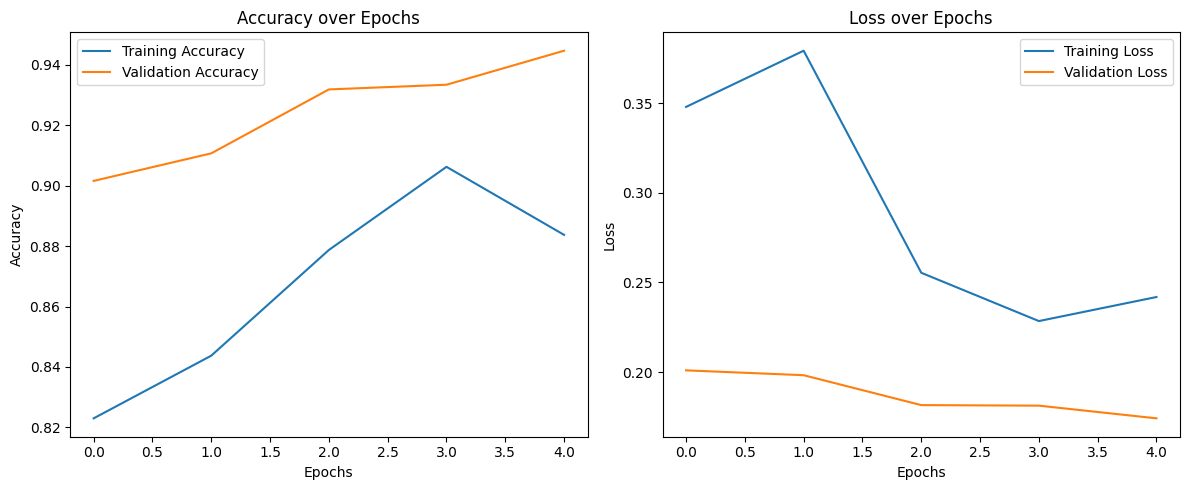

162/162 ━━━━━━━━━━━━━━━━━━━━ 77s 476ms/step


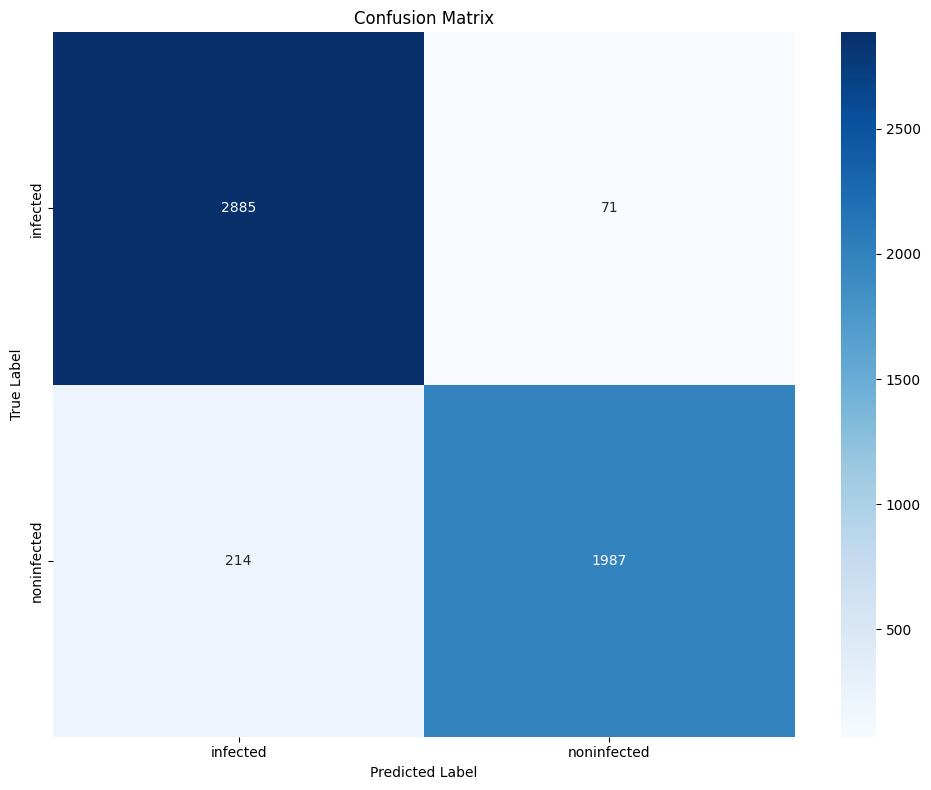


Classification Report:
              precision    recall  f1-score   support

    infected       0.93      0.98      0.95      2956
 noninfected       0.97      0.90      0.93      2201

    accuracy                           0.94      5157
   macro avg       0.95      0.94      0.94      5157
weighted avg       0.95      0.94      0.94      5157



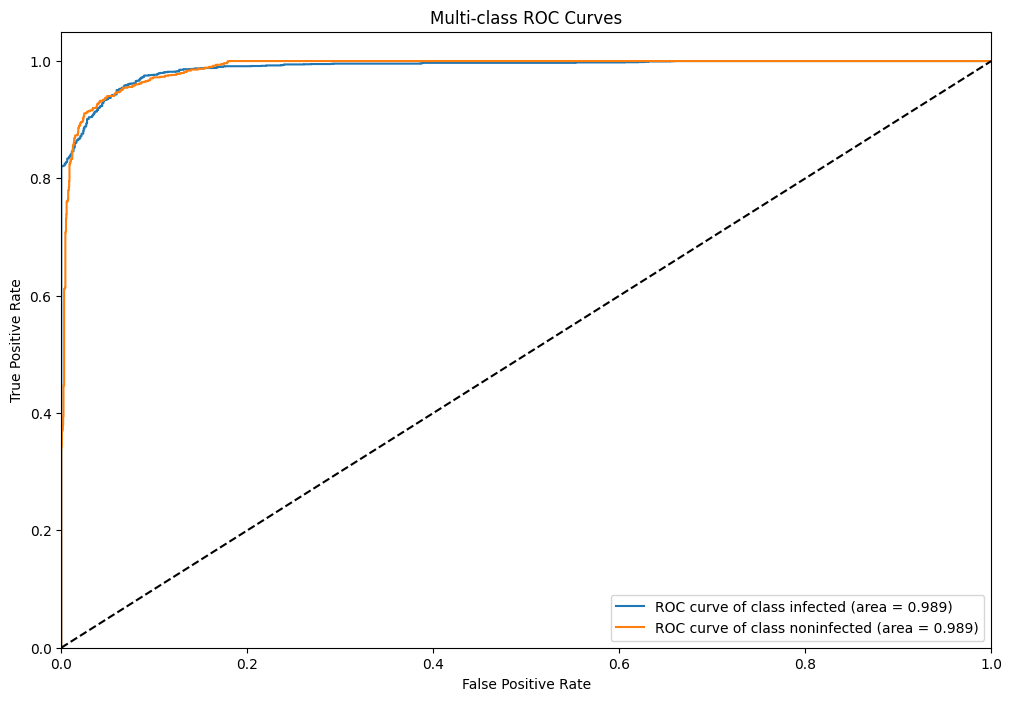


AUC Scores for Each Class:
infected: 0.9891
noninfected: 0.9891


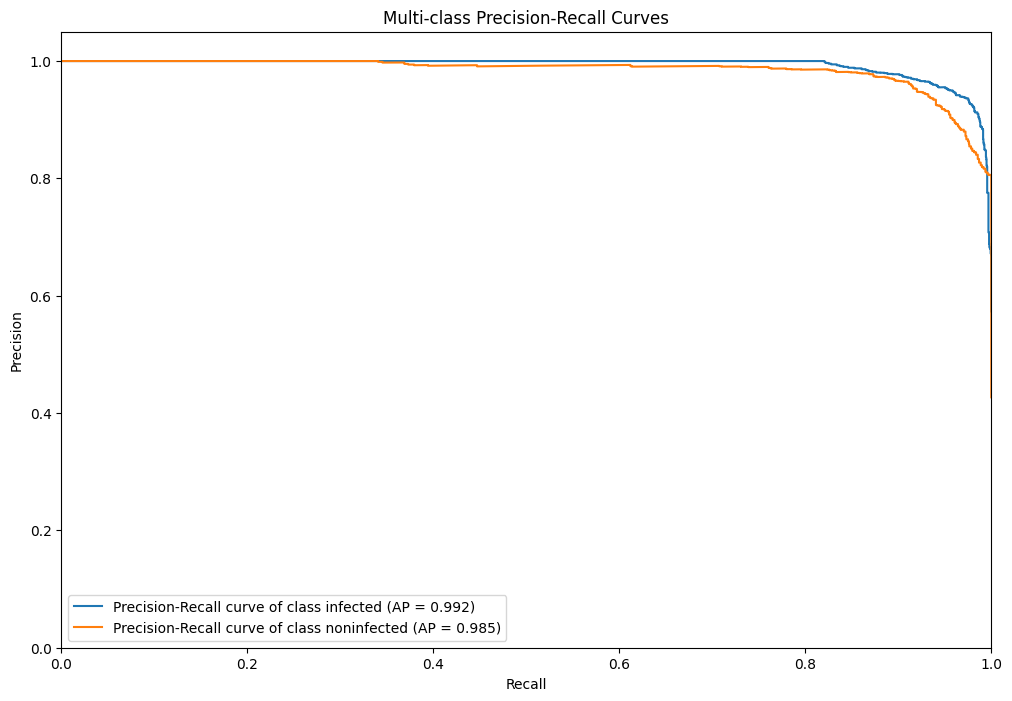


Average Precision Scores for Each Class:
infected: 0.9924
noninfected: 0.9846

Overall Accuracy: 0.9447


In [ ]:
metrics = evaluate_model(history, model, validation_generator)

VGG16 MODEL


Organizing data into train/validation sets...
Creating data generators...
Found 11771 images belonging to 2 classes.
Found 9011 images belonging to 2 classes.
Class indices: {'infected': 0, 'noninfected': 1}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
368/368 ━━━━━━━━━━━━━━━━━━━━ 11966s 33s/step - accuracy: 0.6803 - auc: 0.7332 - loss: 0.5789 - precision: 0.6419 - recall: 0.5131 - val_accuracy: 0.9006 - val_auc: 0.9744 - val_loss: 0.2369 - val_precision: 0.8147 - val_recall: 0.9908 - learning_rate: 1.0000e-04
Epoch 2/2
368/368 ━━━━━━━━━━━━━━━━━━━━ 11907s 32s/step - accuracy: 0.8787 - auc: 0.9474 - loss: 0.2794 - precision: 0.8196 - recall: 0.9185 - val_accuracy: 0.9407 - val_auc: 0.9922 - val_loss: 0.1517 - val_precision: 0.9003 - val_recall: 0.9673 - learning_rate: 1.0000e-04


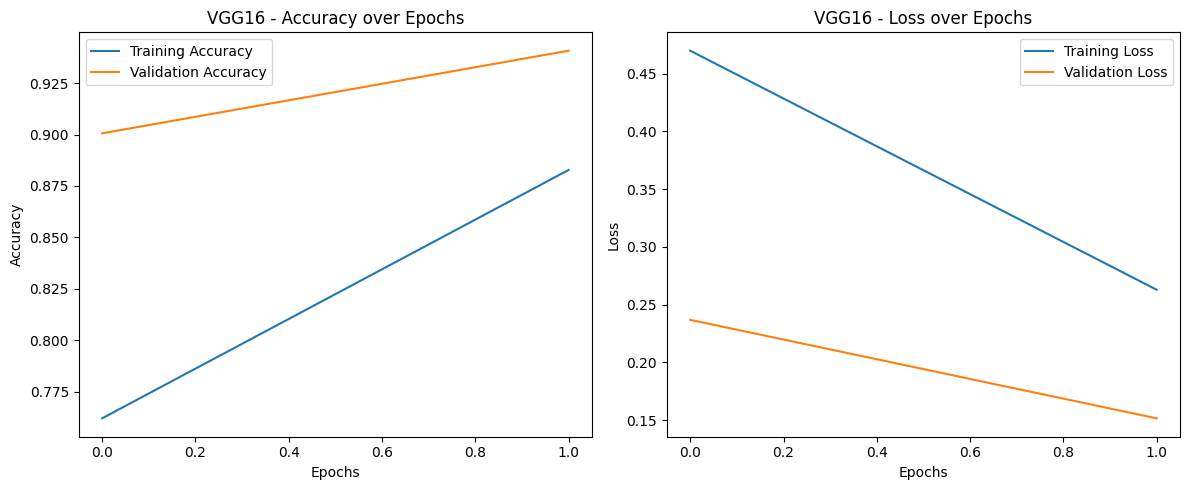


Generating predictions on validation set...
282/282 ━━━━━━━━━━━━━━━━━━━━ 5030s 18s/step

Classification Report:
              precision    recall  f1-score   support

    infected       0.97      0.92      0.95      5191
 noninfected       0.90      0.97      0.93      3820

    accuracy                           0.94      9011
   macro avg       0.94      0.94      0.94      9011
weighted avg       0.94      0.94      0.94      9011



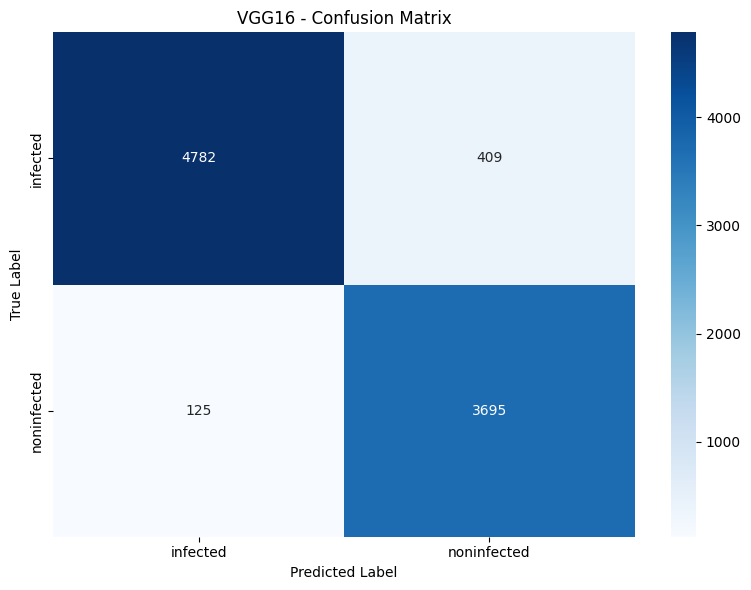

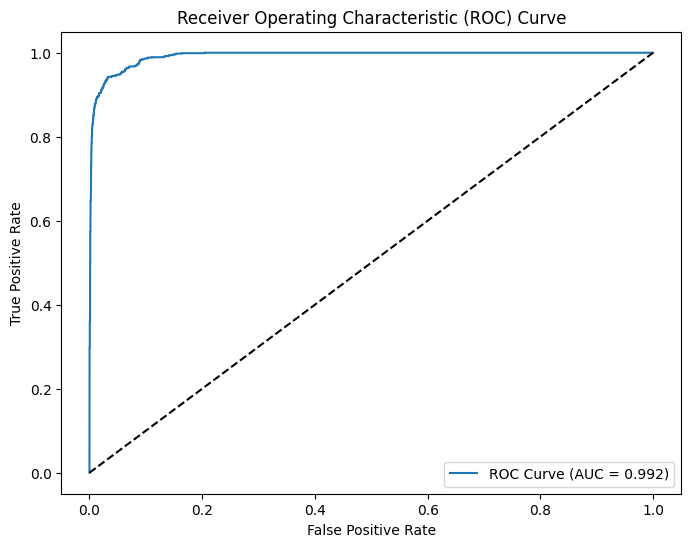

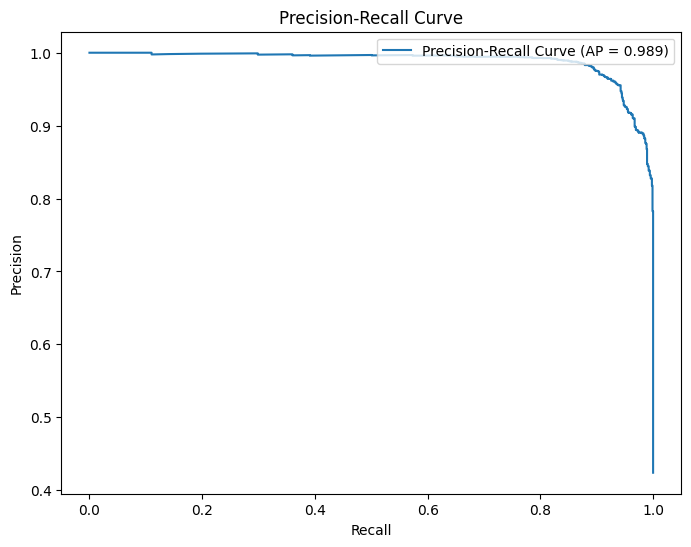


AUC Score: 0.9922
Average Precision Score: 0.9888

Additional Metrics:
Sensitivity (Recall): 0.9673
Specificity: 0.9212
Precision: 0.9003
F1 Score: 0.9326


(<Functional name=functional, built=True>,
 {'auc': np.float64(0.9921694414718991),
  'ap': np.float64(0.9887867750455352),
  'sensitivity': np.float64(0.9672774869109948),
  'specificity': np.float64(0.9212097861683683),
  'precision': np.float64(0.9003411306042886),
  'f1': np.float64(0.9326097930338213)})

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import os
import random
from shutil import copyfile

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 2
DATA_DIR = '/content/drive/MyDrive/Final_Dissertation/DATA'

def shuffle_and_organize_data(data_dir, output_dir):
    """
    Shuffles all images and organizes them into train and validation folders
    """
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get all classes
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    for class_name in classes:
        # Create class directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Get all images for this class
        class_dir = os.path.join(data_dir, class_name)
        images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

        # Shuffle images
        random.shuffle(images)

        # Split into train (75%) and validation (25%)
        split_idx = int(len(images) * 0.75)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copy images to their respective folders
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(train_dir, class_name, img)
            copyfile(src, dst)

        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(val_dir, class_name, img)
            copyfile(src, dst)

    return train_dir, val_dir

def create_data_generators(train_dir, val_dir):
    """Creates separate data generators for training and validation"""

    # For training data - with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )

    # For validation data - only rescaling, no augmentation
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',  # Keep binary for PCOS dataset
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',  # Keep binary for PCOS dataset
        shuffle=False  # False for consistent evaluation
    )

    # Print class indices to know the mapping
    print("Class indices:", train_generator.class_indices)

    return train_generator, val_generator

def build_vgg16_model():
    """Build and compile VGG16 transfer learning model"""

    # Load pre-trained VGG16 model
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))

    # Freeze pretrained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation="sigmoid")(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )

    return model

def train_vgg16():
    """Train the VGG16 model and save results"""

    # First organize data properly
    print("Organizing data into train/validation sets...")
    output_dir = '/content/drive/MyDrive/Final_Dissertation/Organised_Data'
    train_dir, val_dir = shuffle_and_organize_data(DATA_DIR, output_dir)

    # Create proper data generators
    print("Creating data generators...")
    train_generator, val_generator = create_data_generators(train_dir, val_dir)

    # Build the model
    model = build_vgg16_model()
    print(model.summary())

    # Callbacks
    checkpoint = ModelCheckpoint(
        "best_model_vgg16.keras",
        save_best_only=True,
        monitor="val_loss"
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=1
    )

    # Save history to use later for ensemble
    np.save('vgg16_history.npy', history.history)

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('VGG16 - Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('VGG16 - Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('vgg16_training_history.png')
    plt.show()

    # Get the validation dataset predictions
    print("\nGenerating predictions on validation set...")
    # We need to use int() for the steps parameter
    val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))
    val_preds = model.predict(val_generator, steps=val_steps)

    # Save predictions for ensemble model
    np.save('vgg16_val_preds.npy', val_preds)

    # Get actual validation classes (but limit to the number of predictions we have)
    y_true = val_generator.classes[:len(val_preds)]

    # Convert predictions to binary (0 or 1)
    y_pred = (val_preds > 0.5).astype(int).flatten()

    # Get class names for reporting
    class_names = list(val_generator.class_indices.keys())

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('VGG16 - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('vgg16_confusion_matrix.png')
    plt.show()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, val_preds.flatten())
    auc_score = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig('vgg16_roc_curve.png')
    plt.show()

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, val_preds.flatten())
    ap_score = average_precision_score(y_true, val_preds.flatten())

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {ap_score:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.savefig('vgg16_precision_recall_curve.png')
    plt.show()

    # Print additional metrics
    print(f"\nAUC Score: {auc_score:.4f}")
    print(f"Average Precision Score: {ap_score:.4f}")

    # Calculate additional metrics from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)
    precision_score = tp / (tp + fp)
    f1 = 2 * (precision_score * sensitivity) / (precision_score + sensitivity)

    print("\nAdditional Metrics:")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Save model for later use
    model.save('vgg16_final_model.keras')

    # Return relevant objects
    return model, history, {
        'auc': auc_score,
        'ap': ap_score,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_score,
        'f1': f1
    }


train_vgg16()

ResNet50 model


Found 11771 images belonging to 2 classes.
Found 9011 images belonging to 2 classes.
Class indices: {'infected': 0, 'noninfected': 1}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 4250s 12s/step - accuracy: 0.5824 - auc: 0.5930 - loss: 0.6935 - precision: 0.5151 - recall: 0.3775 - val_accuracy: 0.6654 - val_auc: 0.8502 - val_loss: 0.5341 - val_precision: 0.7412 - val_recall: 0.3238 - learning_rate: 1.0000e-04
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 3694s 10s/step - accuracy: 0.7250 - auc: 0.8274 - loss: 0.5360 - precision: 0.7020 - recall: 0.6058 - val_accuracy: 0.7844 - val_auc: 0.8572 - val_loss: 0.4610 - val_precision: 0.7111 - val_recall: 0.8275 - learning_rate: 1.0000e-04
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 3754s 10s/step - accuracy: 0.7760 - auc: 0.8550 - loss: 0.4791 - precision: 0.7159 - recall: 0.7864 - val_accuracy: 0.7413 - val_auc: 0.8697 - val_loss: 0.4511 - val_precision: 0.7395 - val_recall: 0.6018 - learning_rate: 1.0000e-04
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 3553s 10s/step - accuracy: 0.7887 - auc: 0.8609 - loss: 0.4469 - precision: 0.7187 - recall: 0.8222 - val_accuracy: 0.8031 - val_auc: 0.8786 - va

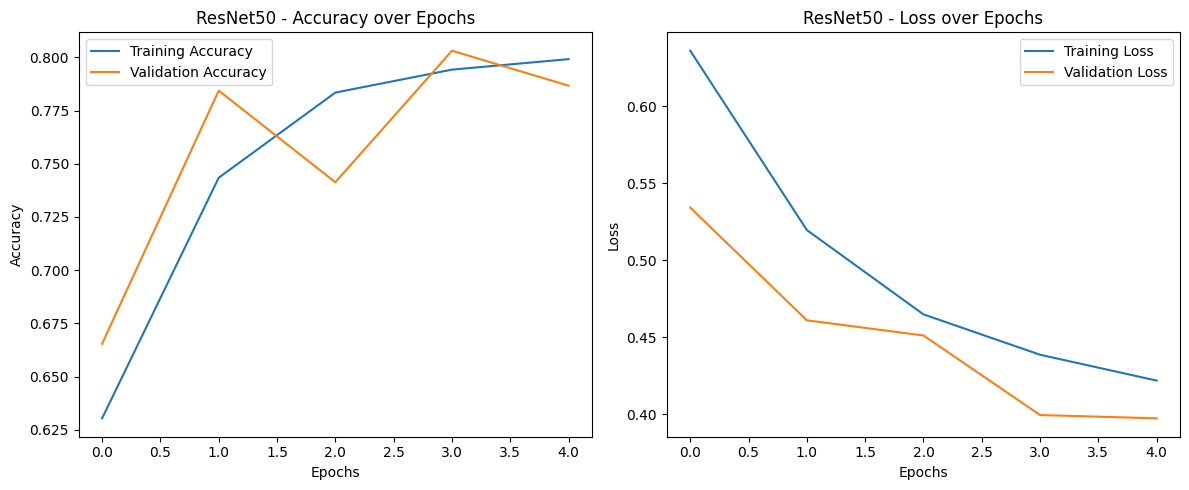

282/282 ━━━━━━━━━━━━━━━━━━━━ 1533s 5s/step

Classification Report:
              precision    recall  f1-score   support

    infected       0.83      0.79      0.81      5191
 noninfected       0.73      0.78      0.76      3820

    accuracy                           0.79      9011
   macro avg       0.78      0.79      0.78      9011
weighted avg       0.79      0.79      0.79      9011



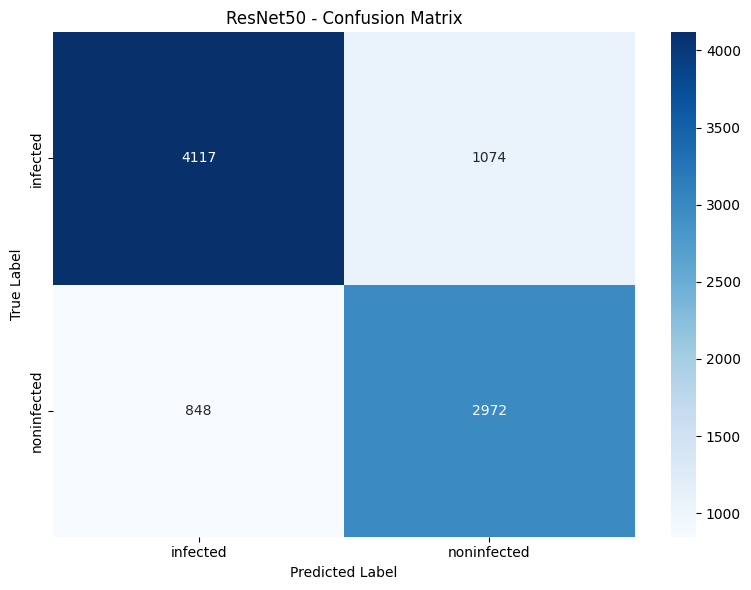

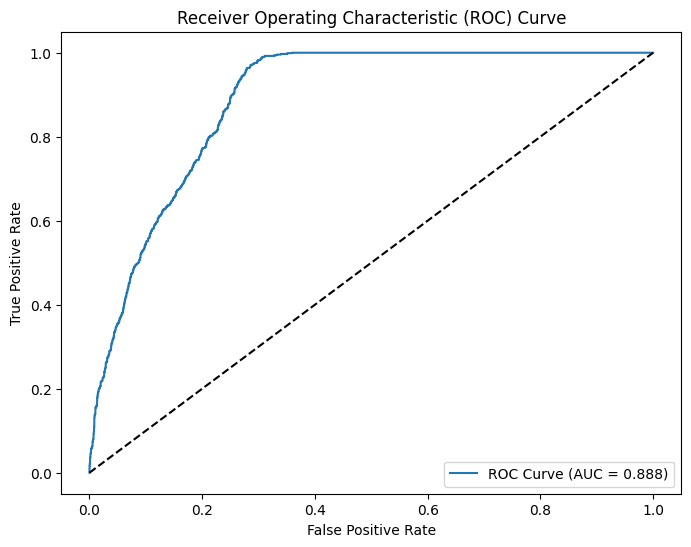

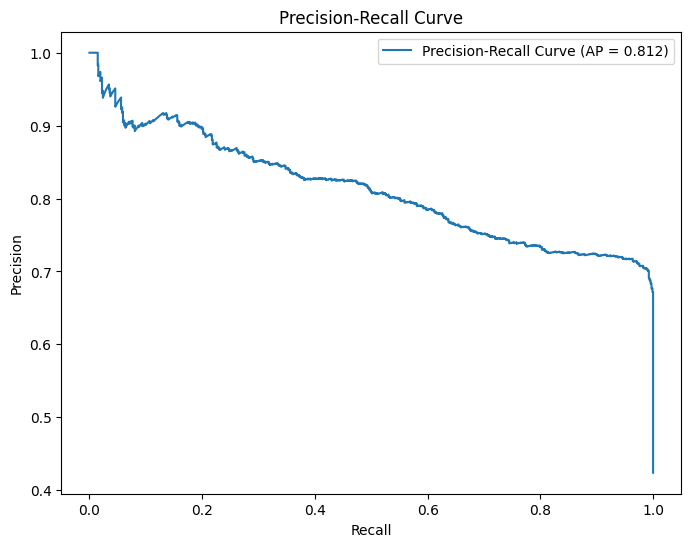


Detailed Metrics:
AUC Score: 0.8878
Average Precision Score: 0.8123
Sensitivity (Recall): 0.7780
Specificity: 0.7931
Precision: 0.7346
F1 Score: 0.7557
282/282 ━━━━━━━━━━━━━━━━━━━━ 1552s 6s/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

# Paths to your balanced data in Kaggle working directory
TRAIN_DIR = '/content/drive/MyDrive/Final_Dissertation/Organised_Data/train'  # Update this path
VAL_DIR = '/content/drive/MyDrive/Final_Dissertation/Organised_Data/val'      # Update this path

# Create data generators for the balanced data
def create_data_generators():
    """Creates data generators for training and validation using the balanced data"""

    # For training data - with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )

    # For validation data - only rescaling, no augmentation
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators using the balanced directories
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False  # No shuffling for validation
    )

    # Print class indices to know the mapping
    print("Class indices:", train_generator.class_indices)

    return train_generator, val_generator

def build_resnet50_model():
    """Build and compile ResNet50 transfer learning model"""

    # Load pre-trained ResNet50 model
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))

    # Freeze pretrained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

def evaluate_resnet50_model(model, val_generator):
    """Comprehensive evaluation of the ResNet50 model with detailed metrics"""

    # Get validation predictions
    val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))
    val_preds = model.predict(val_generator, steps=val_steps)

    # Get true labels (limit to number of predictions we have)
    y_true = val_generator.classes[:len(val_preds)]

    # Convert predictions to binary (0 or 1)
    y_pred = (val_preds > 0.5).astype(int).flatten()

    # Get class names
    class_names = list(val_generator.class_indices.keys())

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('ResNet50 - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('resnet50_confusion_matrix.png')
    plt.show()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, val_preds.flatten())
    auc_score = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig('resnet50_roc_curve.png')
    plt.show()

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, val_preds.flatten())
    ap_score = average_precision_score(y_true, val_preds.flatten())

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {ap_score:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.savefig('resnet50_precision_recall_curve.png')
    plt.show()

    # Calculate additional metrics from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)
    precision_score = tp / (tp + fp)
    f1 = 2 * (precision_score * sensitivity) / (precision_score + sensitivity)

    print("\nDetailed Metrics:")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Average Precision Score: {ap_score:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return {
        'auc': auc_score,
        'ap': ap_score,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_score,
        'f1': f1
    }

def train_resnet50():
    """Train the ResNet50 model and save results with comprehensive evaluation"""

    # Create data generators for the balanced data
    train_generator, val_generator = create_data_generators()

    # Build the model
    model = build_resnet50_model()
    print(model.summary())

    # Callbacks
    checkpoint = ModelCheckpoint(
        "best_model_resnet50.keras",
        save_best_only=True,
        monitor="val_loss"
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=1
    )

    # Save history to use later for ensemble
    np.save('resnet50_history.npy', history.history)

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('ResNet50 - Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ResNet50 - Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('resnet50_training_history.png')
    plt.show()

    # Comprehensive evaluation
    metrics = evaluate_resnet50_model(model, val_generator)

    # Save model's predictions on validation set for ensemble model
    val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))
    val_preds = model.predict(val_generator, steps=val_steps)
    np.save('resnet50_val_preds.npy', val_preds)

    # Save model for later use in ensemble
    model.save('resnet50_final_model.keras')

    return model, history, metrics, train_generator, val_generator


model, history, metrics, train_generator, val_generator = train_resnet50()

Inception model


Found 11771 images belonging to 2 classes.
Found 9011 images belonging to 2 classes.
Class indices: {'infected': 0, 'noninfected': 1}
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,983,457 (87.67 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 5944s 16s/step - accuracy: 0.7834 - auc: 0.8626 - loss: 0.4297 - precision: 0.7398 - recall: 0.7517 - val_accuracy: 0.9134 - val_auc: 0.9779 - val_loss: 0.1926 - val_precision: 0.8545 - val_recall: 0.9592 - learning_rate: 1.0000e-04
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 5685s 15s/step - accuracy: 0.8956 - auc: 0.9651 - loss: 0.2293 - precision: 0.8535 - recall: 0.9097 - val_accuracy: 0.9030 - val_auc: 0.9852 - val_loss: 0.1961 - val_precision: 0.8213 - val_recall: 0.9856 - learning_rate: 1.0000e-04
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 5521s 15s/step - accuracy: 0.9113 - auc: 0.9731 - loss: 0.1990 - precision: 0.8745 - recall: 0.9243 - val_accuracy: 0.9314 - val_auc: 0.9820 - val_loss: 0.1642 - val_precision: 0.9009 - val_recall: 0.9419 - learning_rate: 1.0000e-04
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 5522s 15s/step - accuracy: 0.9149 - auc: 0.9773 - loss: 0.1852 - precision: 0.8847 - recall: 0.9224 - val_accuracy: 0.9175 - val_auc: 0.9829 - va

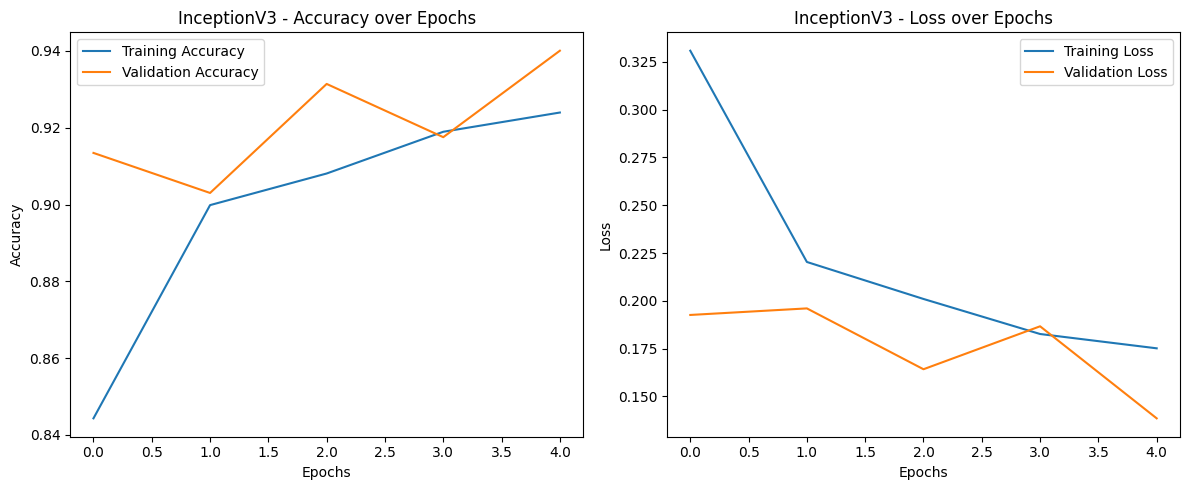

282/282 ━━━━━━━━━━━━━━━━━━━━ 2295s 8s/step

Classification Report:
              precision    recall  f1-score   support

    infected       0.98      0.91      0.95      5191
 noninfected       0.89      0.98      0.93      3820

    accuracy                           0.94      9011
   macro avg       0.94      0.95      0.94      9011
weighted avg       0.94      0.94      0.94      9011



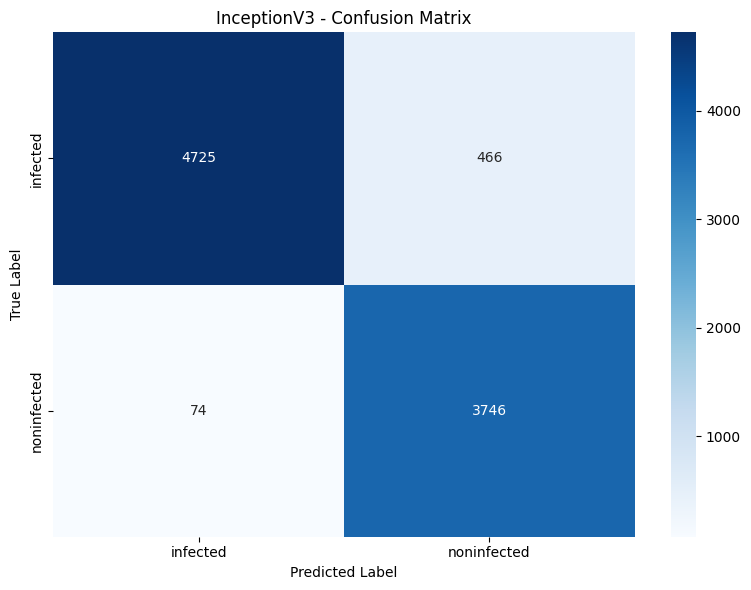

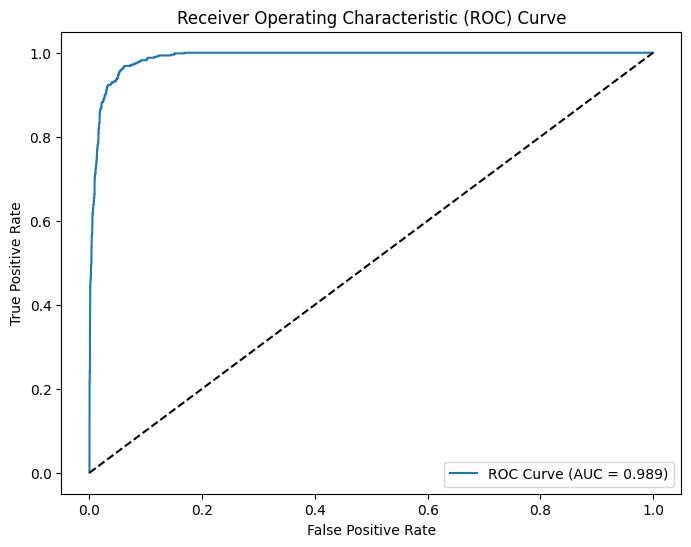

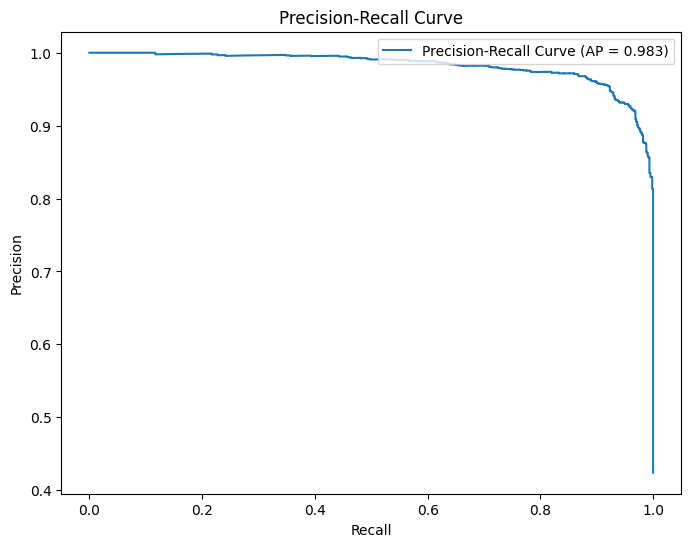


Detailed Metrics:
AUC Score: 0.9888
Average Precision Score: 0.9826
Sensitivity (Recall): 0.9806
Specificity: 0.9102
Precision: 0.8894
F1 Score: 0.9328
282/282 ━━━━━━━━━━━━━━━━━━━━ 2297s 8s/step


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Constants
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 5

# Paths to your balanced data in Kaggle working directory
TRAIN_DIR = '/content/drive/MyDrive/Final_Dissertation/Organised_Data/train'  # Update this path if needed
VAL_DIR = '/content/drive/MyDrive/Final_Dissertation/Organised_Data/val'      # Update this path if needed


# Create data generators for the balanced data
def create_data_generators():
    """Creates data generators for training and validation using the balanced data"""

    # For training data - with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )

    # For validation data - only rescaling, no augmentation
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators using the balanced directories
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False  # No shuffling for validation
    )

    # Print class indices to know the mapping
    print("Class indices:", train_generator.class_indices)

    return train_generator, val_generator

def build_inception_model():
    """Build and compile InceptionV3 transfer learning model"""

    # Load pre-trained InceptionV3 model
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))

    # Freeze pretrained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation="sigmoid")(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

def evaluate_inception_model(model, val_generator):
    """Comprehensive evaluation of the InceptionV3 model with detailed metrics"""

    # Get validation predictions
    val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))
    val_preds = model.predict(val_generator, steps=val_steps)

    # Get true labels (limit to number of predictions we have)
    y_true = val_generator.classes[:len(val_preds)]

    # Convert predictions to binary (0 or 1)
    y_pred = (val_preds > 0.5).astype(int).flatten()

    # Get class names
    class_names = list(val_generator.class_indices.keys())

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('InceptionV3 - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('inception_confusion_matrix.png')
    plt.show()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, val_preds.flatten())
    auc_score = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig('inception_roc_curve.png')
    plt.show()

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, val_preds.flatten())
    ap_score = average_precision_score(y_true, val_preds.flatten())

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {ap_score:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.savefig('inception_precision_recall_curve.png')
    plt.show()

    # Calculate additional metrics from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)
    precision_score = tp / (tp + fp)
    f1 = 2 * (precision_score * sensitivity) / (precision_score + sensitivity)

    print("\nDetailed Metrics:")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Average Precision Score: {ap_score:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return {
        'auc': auc_score,
        'ap': ap_score,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_score,
        'f1': f1
    }

def train_inception():
    """Train the InceptionV3 model and save results with comprehensive evaluation"""

    # Create data generators for the balanced data
    train_generator, val_generator = create_data_generators()

    # Build the model
    model = build_inception_model()
    print(model.summary())

    # Callbacks
    checkpoint = ModelCheckpoint(
        "best_model_inception.keras",
        save_best_only=True,
        monitor="val_loss"
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=1
    )

    # Save history to use later for ensemble
    np.save('inception_history.npy', history.history)

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('InceptionV3 - Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('InceptionV3 - Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('inception_training_history.png')
    plt.show()

    # Comprehensive evaluation
    metrics = evaluate_inception_model(model, val_generator)

    # Save model's predictions on validation set for ensemble model
    val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))
    val_preds = model.predict(val_generator, steps=val_steps)
    np.save('inception_val_preds.npy', val_preds)

    # Save model for later use in ensemble
    model.save('inception_final_model.keras')

    return model, history, metrics, train_generator, val_generator

model, history, metrics, train_generator, val_generator = train_inception()

Found 8657 images belonging to 2 classes.
Found 8657 images belonging to 2 classes.
Found 8657 images belonging to 2 classes.
Loaded model from /content/drive/MyDrive/Project/best_model_vgg16.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


271/271 ━━━━━━━━━━━━━━━━━━━━ 6206s 23s/step
Loaded model from /content/drive/MyDrive/Project/best_model_resnet50.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 1749s 6s/step
Loaded model from /content/drive/MyDrive/Project/best_model_inception.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 2932s 11s/step
Loaded model from /content/drive/MyDrive/Project/best_model.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step
Successfully loaded 4 models for ensemble.

Evaluating ensemble with equal weights:

Ensemble Model - Classification Report:
              precision    recall  f1-score   support

    infected       1.00      0.89      0.94      5163
 noninfected       0.86      1.00      0.92      3494

    accuracy                           0.93      8657
   macro avg       0.93      0.94      0.93      8657
weighted avg       0.94      0.93      0.93      8657



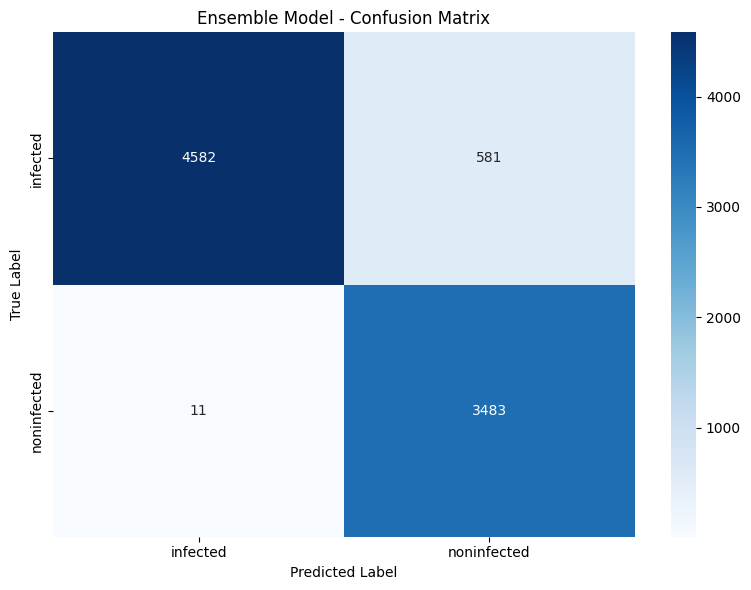

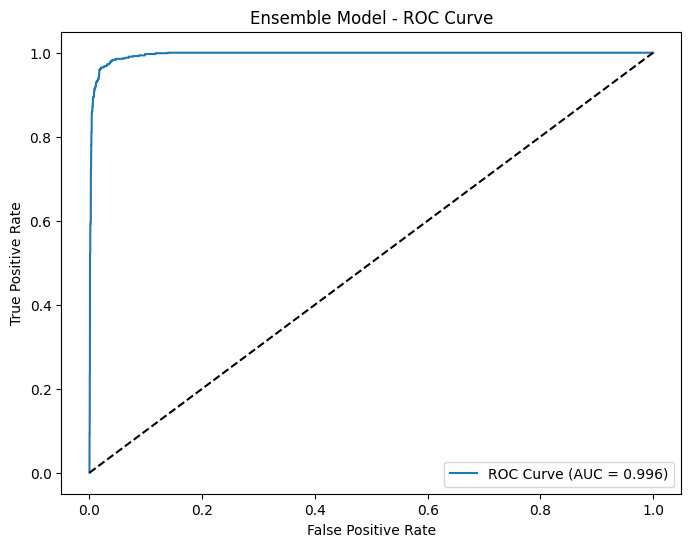

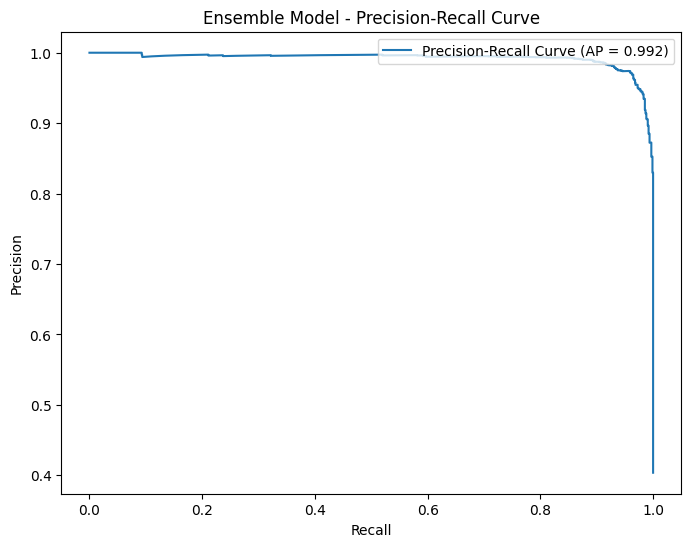


Ensemble Model - Detailed Metrics:
AUC Score: 0.9957
Average Precision Score: 0.9921
Sensitivity (Recall): 0.9969
Specificity: 0.8875
Precision: 0.8570
F1 Score: 0.9217

Comparison with individual models:
VGG16 Accuracy: 0.9678
ResNet50 Accuracy: 0.8163
InceptionV3 Accuracy: 0.9232
Custom CNN Accuracy: 0.9064
Ensemble Accuracy: 0.9316

Finding optimal weights for ensemble...
Best weights found: [0.57142857 0.14285714 0.14285714 0.14285714] with accuracy: 0.9633

Evaluating ensemble with optimal weights:

Ensemble Model - Classification Report:
              precision    recall  f1-score   support

    infected       1.00      0.94      0.97      5163
 noninfected       0.92      1.00      0.96      3494

    accuracy                           0.96      8657
   macro avg       0.96      0.97      0.96      8657
weighted avg       0.97      0.96      0.96      8657



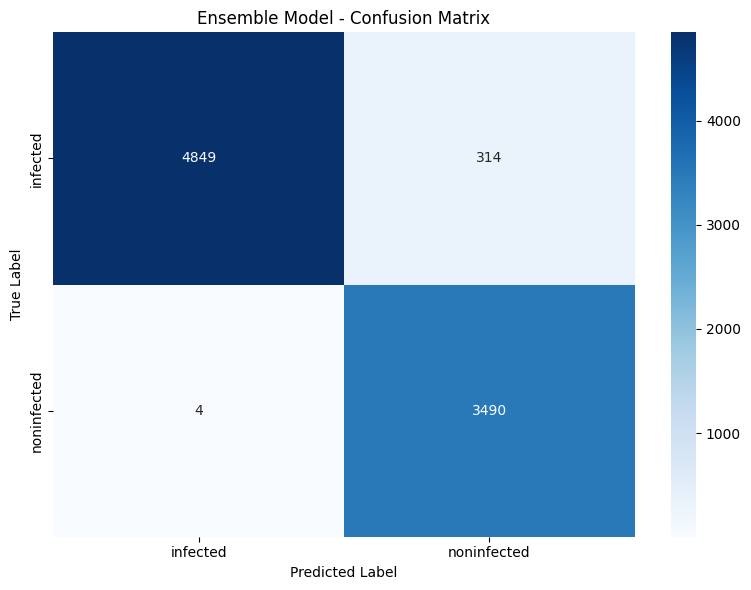

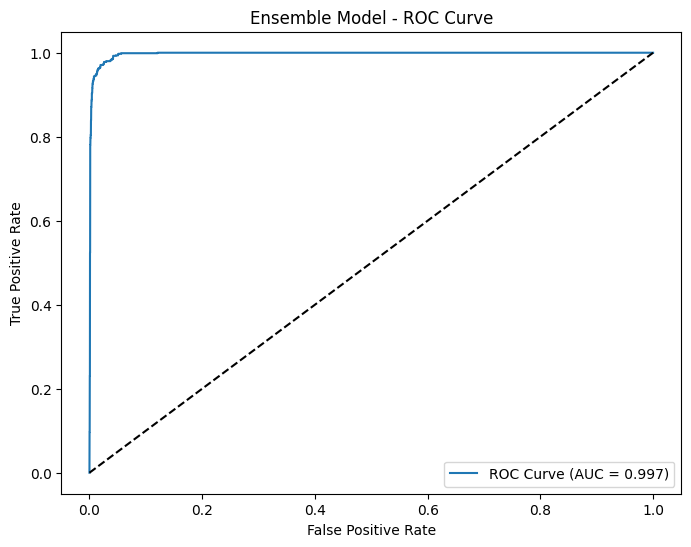

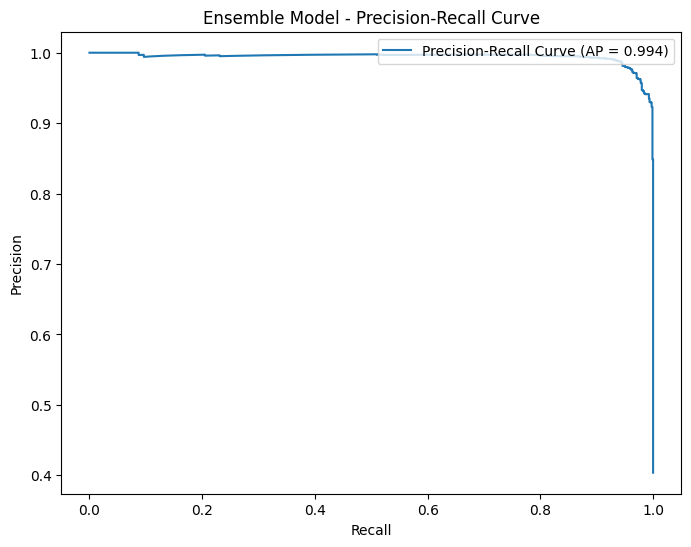


Ensemble Model - Detailed Metrics:
AUC Score: 0.9972
Average Precision Score: 0.9945
Sensitivity (Recall): 0.9989
Specificity: 0.9392
Precision: 0.9175
F1 Score: 0.9564

Comparison with individual models:
VGG16 Accuracy: 0.9678
ResNet50 Accuracy: 0.8163
InceptionV3 Accuracy: 0.9232
Custom CNN Accuracy: 0.9064
Ensemble Accuracy: 0.9633

Comparison between equal and optimal weights:
Equal weights accuracy: 0.9316
Optimal weights accuracy: 0.9633


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import os

# Constants
IMG_SIZE_VGG_RESNET = (224, 224)  # VGG16 and ResNet50 use 224x224
IMG_SIZE_INCEPTION = (299, 299)    # InceptionV3 uses 299x299
BATCH_SIZE = 32

# Paths to your balanced data in Kaggle working directory
TRAIN_DIR = '/content/drive/MyDrive/Project/OUTPUT_DATA/train'  # Update this path if needed
VAL_DIR = '/content/drive/MyDrive/Project/OUTPUT_DATA/val'      # Update this path if needed


# Model paths
VGG16_MODEL_PATH = '/content/drive/MyDrive/Project/best_model_vgg16.keras'
RESNET50_MODEL_PATH = '/content/drive/MyDrive/Project/best_model_resnet50.keras'
INCEPTION_MODEL_PATH = '/content/drive/MyDrive/Project/best_model_inception.keras'
CUSTOM_MODEL_PATH = '/content/drive/MyDrive/Project/best_model.keras'

def create_validation_generators():
    """Create validation generators for different input sizes"""

    # Validation generator for VGG16 and ResNet50 (224x224) - Binary
    val_datagen_224 = ImageDataGenerator(rescale=1./255)
    val_generator_224 = val_datagen_224.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE_VGG_RESNET,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    # Validation generator for InceptionV3 (299x299) - Binary
    val_datagen_299 = ImageDataGenerator(rescale=1./255)
    val_generator_299 = val_datagen_299.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE_INCEPTION,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    # Validation generator for Custom CNN (224x224) - Categorical
    val_datagen_categorical = ImageDataGenerator(rescale=1./255)
    val_generator_categorical = val_datagen_categorical.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE_VGG_RESNET,
        batch_size=BATCH_SIZE,
        class_mode='categorical',  # Changed to categorical
        shuffle=False
    )

    return val_generator_224, val_generator_299, val_generator_categorical

def get_model_predictions(model_path, val_generator, is_categorical=False):
    """Get predictions from a model for the validation set"""
    try:
        # Load the model
        model = load_model(model_path)
        print(f"Loaded model from {model_path}")

        # Make predictions
        val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))
        predictions = model.predict(val_generator, steps=val_steps)

        # Reset generator for next use
        val_generator.reset()

        # Handle categorical output (take the positive class probability)
        if is_categorical:
            # If binary categorical, take the second column (index 1)
            # which represents probability of positive class
            if predictions.shape[1] == 2:
                return predictions[:, 1].flatten()
            else:
                print(f"Warning: Expected binary categorical output, but got {predictions.shape[1]} classes.")
                # Return the highest probability class as a workaround
                return np.max(predictions, axis=1).flatten()
        else:
            return predictions.flatten()

    except Exception as e:
        print(f"Error loading or predicting with model {model_path}: {e}")
        return None

def evaluate_ensemble(all_predictions, val_generator, weights=None):
    """Evaluate the ensemble model with optional weighting of individual models"""

    # If weights are provided, apply them to the predictions
    if weights is None:
        # Default: equal weights for all models
        weights = np.ones(len(all_predictions)) / len(all_predictions)

    # Apply weights and compute weighted average
    weighted_preds = np.zeros(len(all_predictions[0]))
    for i, preds in enumerate(all_predictions):
        weighted_preds += weights[i] * preds

    # Get true labels
    y_true = val_generator.classes[:len(weighted_preds)]

    # Convert to binary predictions
    y_pred = (weighted_preds > 0.5).astype(int)

    # Get class names
    class_names = list(val_generator.class_indices.keys())

    # Print classification report
    print("\nEnsemble Model - Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Ensemble Model - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('ensemble_confusion_matrix.png')
    plt.show()

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, weighted_preds)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Ensemble Model - ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig('ensemble_roc_curve.png')
    plt.show()

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, weighted_preds)
    ap_score = average_precision_score(y_true, weighted_preds)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {ap_score:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Ensemble Model - Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.savefig('ensemble_precision_recall_curve.png')
    plt.show()

    # Calculate additional metrics from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)
    precision_score = tp / (tp + fp)
    f1 = 2 * (precision_score * sensitivity) / (precision_score + sensitivity)

    print("\nEnsemble Model - Detailed Metrics:")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Average Precision Score: {ap_score:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compare with individual models
    print("\nComparison with individual models:")
    for i, model_name in enumerate(['VGG16', 'ResNet50', 'InceptionV3', 'Custom CNN']):
        pred_binary = (all_predictions[i] > 0.5).astype(int)
        acc = np.mean(pred_binary == y_true)
        print(f"{model_name} Accuracy: {acc:.4f}")

    ensemble_acc = np.mean(y_pred == y_true)
    print(f"Ensemble Accuracy: {ensemble_acc:.4f}")

    return {
        'auc': auc_score,
        'ap': ap_score,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_score,
        'f1': f1,
        'accuracy': ensemble_acc,
        'predictions': weighted_preds
    }

def optimize_ensemble_weights(all_predictions, y_true):
    """
    Simple grid search to find optimal weights for models.
    This is a basic approach - you could use more sophisticated methods.
    """
    best_acc = 0
    best_weights = None

    # Try different weight combinations
    for w1 in np.linspace(0.1, 0.4, 4):
        for w2 in np.linspace(0.1, 0.4, 4):
            for w3 in np.linspace(0.1, 0.4, 4):
                for w4 in np.linspace(0.1, 0.4, 4):
                    # Normalize weights to sum to 1
                    weights = np.array([w1, w2, w3, w4])
                    weights = weights / np.sum(weights)

                    # Calculate weighted prediction
                    weighted_preds = np.zeros(len(all_predictions[0]))
                    for i, preds in enumerate(all_predictions):
                        weighted_preds += weights[i] * preds

                    # Convert to binary and calculate accuracy
                    y_pred = (weighted_preds > 0.5).astype(int)
                    acc = np.mean(y_pred == y_true)

                    if acc > best_acc:
                        best_acc = acc
                        best_weights = weights

    print(f"Best weights found: {best_weights} with accuracy: {best_acc:.4f}")
    return best_weights

def create_ensemble():
    """Create and evaluate an ensemble model from the trained models"""

    # Create validation generators
    val_generator_224, val_generator_299, val_generator_categorical = create_validation_generators()

    # Get predictions from each model
    vgg16_preds = get_model_predictions(VGG16_MODEL_PATH, val_generator_224)
    resnet50_preds = get_model_predictions(RESNET50_MODEL_PATH, val_generator_224)
    inception_preds = get_model_predictions(INCEPTION_MODEL_PATH, val_generator_299)
    custom_preds = get_model_predictions(CUSTOM_MODEL_PATH, val_generator_categorical, is_categorical=True)

    # Check if all predictions were successfully retrieved
    all_preds = [vgg16_preds, resnet50_preds, inception_preds, custom_preds]
    valid_preds = [p for p in all_preds if p is not None]

    if len(valid_preds) < 2:
        print("Not enough valid model predictions for ensemble.")
        return

    print(f"Successfully loaded {len(valid_preds)} models for ensemble.")

    # Get ground truth labels
    y_true = val_generator_224.classes[:len(valid_preds[0])]

    # First try with equal weights
    print("\nEvaluating ensemble with equal weights:")
    equal_weights = np.ones(len(valid_preds)) / len(valid_preds)
    equal_metrics = evaluate_ensemble(valid_preds, val_generator_224, equal_weights)

    # Try to find optimal weights
    print("\nFinding optimal weights for ensemble...")
    optimal_weights = optimize_ensemble_weights(valid_preds, y_true)

    # Evaluate with optimal weights
    print("\nEvaluating ensemble with optimal weights:")
    optimal_metrics = evaluate_ensemble(valid_preds, val_generator_224, optimal_weights)

    # Compare the two approaches
    print("\nComparison between equal and optimal weights:")
    print(f"Equal weights accuracy: {equal_metrics['accuracy']:.4f}")
    print(f"Optimal weights accuracy: {optimal_metrics['accuracy']:.4f}")

    # Save the ensemble predictions for further analysis
    np.save('ensemble_equal_weights_preds.npy', equal_metrics['predictions'])
    np.save('ensemble_optimal_weights_preds.npy', optimal_metrics['predictions'])

    return equal_metrics, optimal_metrics

if __name__ == "__main__":
    # Create and evaluate the ensemble model
    equal_metrics, optimal_metrics = create_ensemble()